In [1]:
import os
import pickle
import sys
from matplotlib import pyplot as plt

import json
import numpy as np
import torch

from datetime import datetime
from utils import Json_Parser

import torch
from torch.utils.data.dataloader import DataLoader
from dataset import NuSceneDataset
from torch import optim,Tensor,unsqueeze
from torch.utils.data.dataset import Dataset
import torch.autograd
import torch.nn as nn
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm import tqdm

from utils import Json_Parser

# 数据

In [2]:
config_file_name='./config.json'
parser = Json_Parser(config_file_name)
config = parser.load_parser()
load_mode = False
train_dataloader = DataLoader(NuSceneDataset(train_mode=1-load_mode, config_file_name=config_file_name, verbose=False), 
                              batch_size=config['LEARNING']['batch_size'], shuffle=True, num_workers=8, prefetch_factor = 2,
                              pin_memory = True, persistent_workers=True)
len(train_dataloader)

371

# 模型构建

## 参数

In [3]:
# 基本参数
if config['LEARNING']['device'] == 'cuda:0':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
torch.backends.cudnn.benchmark = True

epochs = 1
latent_dim = 256  # LSTM 的单元个数
encoder_fc = 64
num_layers = 2
bidirectional = True

encoder_length = 1 
decoder_length = 10
num_encoder_tokens = 2
num_decoder_tokens = 2
z_dimension = 32
accumulation_steps = 5 # 梯度累积步数

num_classes = config['LEARNING']['num_classes'] # 类数
modal_fc = latent_dim*(1+bidirectional) 

## 损失函数

In [4]:
def neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor
) -> Tensor:
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
#     assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
#     assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
#     avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred)) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)

def loss_function(y_hat, confidences, data, mean1, std1, mean2, std2):
    label = data['label'].to(device)
    y_true = data["target_positions"].to(device)
#     MSE = F.mse_loss(y_hat, y_true, reduction='none')
#     MSE = MSE * y_availabilities
#     MSE = MSE.mean()
    Cross = F.binary_cross_entropy_with_logits(confidences, label)
    NLL = neg_multi_log_likelihood_batch(
        y_true, y_hat, confidences)
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var1 = torch.pow(torch.exp(std1), 2)
    var2 = torch.pow(torch.exp(std2), 2)
    KLD1 = -0.5 * torch.mean(1+torch.log(var1)-torch.pow(mean1, 2)-var1)
    KLD1 = torch.max(KLD1,torch.ones_like(KLD1))
    KLD2 = -0.5 * torch.mean(1+torch.log(var2)-torch.pow(mean2, 2)-var2)
    KLD2 = torch.max(KLD2,torch.ones_like(KLD2))
    KLD = KLD1 + KLD2
#     print('KLD: ',KLD,' NLL: ',NLL,' Cross: ', Cross)
    return NLL, KLD, Cross

## 模型

In [5]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        # 定义序列编码器
        self.encoder = nn.LSTM(
            num_encoder_tokens, latent_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.encoder2 = nn.Linear(latent_dim*(1+bidirectional), encoder_fc)
#         self.encoder2 = nn.Linear(latent_dim*(1+bidirectional)+modal_fc, encoder_fc)
#         self.encoder_mean1 = nn.Linear(latent_dim*(1+bidirectional), 64)
        self.encoder_mean2 = nn.Linear(encoder_fc, z_dimension)
#         self.encoder_std1 = nn.Linear(latent_dim*(1+bidirectional), 32)
        self.encoder_std2 = nn.Linear(encoder_fc, z_dimension)

        # 定义序列解码器
        self.decoder = nn.LSTM(z_dimension*2, latent_dim, num_layers=num_layers,
                               bidirectional=bidirectional, batch_first=True)
        self.decoder_fc = nn.Linear(latent_dim*(1+bidirectional), 64)
        self.decoder_fc1 = nn.Linear(64, num_decoder_tokens*num_classes)
#         self.decoder_fc2 = nn.Linear(64, num_decoder_tokens)
#         self.decoder_fc3 = nn.Linear(64, num_decoder_tokens)
        self.decoder_confi = nn.Linear(num_decoder_tokens*num_classes, num_classes)

        # 定义图像编码器
        # load pre-trained Conv2D model
        self.resnet = resnet50(pretrained=True)
        # change input channels number to match the rasterizer's output
        num_in_channels = 3
        self.resnet.conv1 = nn.Conv2d(
            num_in_channels,
            self.resnet.conv1.out_channels,
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=False,
        )
        # change output size to (X, Y) * number of future states
        num_targets = z_dimension * decoder_length
        self.resnet.fc = nn.Linear(in_features=2048, out_features=512)
        self.encoder_mean3 = nn.Linear(512, num_targets)
        self.encoder_std3 = nn.Linear(512, num_targets)
        
        #定义采样器
        self.sampler_fc1 = nn.Linear(3,1024)
        self.sampler_fc2 = nn.Linear(1024,512)
        self.sampler_fc3 = nn.Linear(512,z_dimension * decoder_length)
        
        #定义行为预测
        self.modal1 = nn.LSTM(
            num_encoder_tokens, latent_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.modal2 = nn.Linear(latent_dim*(1+bidirectional), num_classes)
        
    def noise_reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, data):
#         print(data["history_positions"])
        inputs1 = data["history_positions"].to(device)
        inputs1 = inputs1.float()
#         yaw = torch.FloatTensor(data["history_yaws"]).to(device)
        if inputs1.dim() == 2:
            inputs1 = torch.unsqueeze(inputs1, 0)

        h0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)
        c0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)

        inputs21 = data["image"].to(device)
        inputs21 = inputs21.float()
        inputs2 = inputs21.permute(0, 3, 1, 2)
        if inputs2.dim() == 3:
            inputs2 = torch.unsqueeze(inputs2, 0)

        out1, _ = self.encoder(inputs1, (h0, c0))
#         out1 = out1[:,-1,:]
#         out1 = torch.unsqueeze(out1, 1)
#         out1 = out1.expand(out1.size()[0],decoder_length,out1.size()[-1])
        out1 = F.relu(self.encoder2(out1), inplace=True)
        
        out_modal, _ = self.modal1(inputs1, (h0, c0))
        out_modal = F.softmax(self.modal2(out_modal[:, -1, :]), dim = -1)

#         mean1 = F.relu(self.encoder_mean1(out1), inplace=True)
        mean2 = F.relu(self.encoder_mean2(out1), inplace=True)
#         logstd1 = F.relu(self.encoder_std1(out1), inplace=True)
        logstd2 = F.relu(self.encoder_std2(out1), inplace=True)
        # prevent from poster vanish
#         logstd2 = torch.abs(logstd2) + 0.6

        z1 = self.noise_reparameterize(mean2, logstd2)
        z1 = z1[:, -1, :]
        z1 = torch.unsqueeze(z1, 1)
        z1 = z1.expand(z1.size()[0], decoder_length, z1.size()[-1])

        out12 = self.resnet(inputs2)
        mean3 = F.relu(self.encoder_mean3(out12), inplace=True)
        logstd3 = F.relu(self.encoder_std3(out12), inplace=True)
        z2 = self.noise_reparameterize(mean3, logstd3)
        z2 = z2.reshape(z1.size())
        z = torch.cat([z1, z2], -1)
        out2, _ = self.decoder(z)
        out2 = F.relu(self.decoder_fc(out2), inplace=True)

        out21 = F.relu(self.decoder_fc1(out2), inplace=True)
#         out22 = F.relu(self.decoder_fc2(out2), inplace=True)
#         out23 = F.relu(self.decoder_fc3(out2), inplace=True)
        confidences = F.softmax(self.decoder_confi(out21)[:, -1, :], dim=-1)
        confidences = F.softmax(confidences * out_modal, dim=-1)
        
        out3 = torch.split(out21,2,dim=-1)
        y_hat = torch.Tensor([]).to(device)
        for i in out3:
            i = torch.unsqueeze(i, 1) 
            y_hat=torch.cat([y_hat,i],dim=1)

        return y_hat, confidences, mean2, logstd2, mean3, logstd3

# 创建对象
cvae = CVAE().to(device)
# vae.load_state_dict(torch.load('./VAE_z2.pth'))
cvae_optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)

## 模型训练

In [6]:
if not load_mode:    
    # ==== TRAIN LOOP
    losses_avg = []
    for epoch in range(epochs):  # 进行多个epoch的训练
        tr_it = iter(train_dataloader)
        progress_bar = tqdm(range(len(train_dataloader)//1),position=0)
        losses_train = []
        cvae_optimizer.zero_grad(set_to_none = True)
        for i in progress_bar:
            try:
                data = next(tr_it)
            except StopIteration:
                tr_it = iter(train_dataloader)
                data = next(tr_it)
            cvae.train() # 设置为训练模式
            torch.set_grad_enabled(True)
#             print(data["image"].size(),data["history_positions"].size(),data["target_positions"].size())
            y_hat, confidences, mean1, std1, mean2, std2 = cvae(data)  # 输入
            if device == 'cuda:0':
                with torch.cuda.amp.autocast():
                    NLL,KLD,Cross = loss_function(y_hat, confidences, data, mean1, std1, mean2, std2)
                    loss = NLL + (25)*KLD + 20*Cross
                    if i + 1>= len(train_dataloader)//1:
                        print(NLL,KLD,Cross)
            else:
                NLL,KLD,Cross = loss_function(y_hat, confidences, data, mean1, std1, mean2, std2)
                loss = NLL + (25)*KLD + 20*Cross
                if i + 1>= len(train_dataloader)//1:
                    print(NLL,KLD,Cross)

            # Backward pass
            # 梯度累积模式
            loss = loss / accumulation_steps
            loss.backward() 
            if (i+1) % accumulation_steps == 0:
                cvae_optimizer.step()
                cvae_optimizer.zero_grad(set_to_none = True)

            # 无梯度累积模式
    #         cvae_optimizer.zero_grad(set_to_none = True)
    #         loss.backward()
    #         cvae_optimizer.step()
            losses_train.append(loss.item())
            progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        losses_avg.append(np.mean(losses_train))

loss: 834.9557494127539 loss(avg): 702.7562994911322: 100%|██████████████████████████| 371/371 [12:36<00:00,  2.04s/it]

tensor(4103.2144, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>) tensor(2.2587, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7549, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


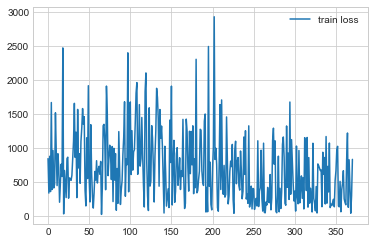

In [7]:
if not load_mode:    
    torch.save(cvae.state_dict(),'E:/Downloads/nuscenes/cvae.pth')
    plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
    plt.legend()
    plt.show()

In [ ]:
from nuscenes.eval.prediction.metrics import mean_distances

config_file_name='./config.json'
parser = Json_Parser(config_file_name)
config = parser.load_parser()
load_mode = True
eval_dataloader = DataLoader(NuSceneDataset(train_mode=1-load_mode, config_file_name=config_file_name, verbose=False), 
                              batch_size=config['LEARNING']['batch_size'], shuffle=True, num_workers=8, prefetch_factor = 2,
                              pin_memory = True, persistent_workers=True)
len(eval_dataloader)

In [ ]:
# ==== EVAL LOOP
cvae.eval()
torch.set_grad_enabled(False)
losses_test = []

# store information for evaluation
future_coords_offsets_pd = []
gt_coords_offsets_pd = []

confs = []
tr_it = iter(eval_dataloader)
progress_bar = tqdm(range(len(eval_dataloader)//1),position=0)

for i in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(eval_dataloader)
        data = next(tr_it)
    y_hat, confidences,mean1,std1,mean2,std2 = cvae(data)
    if cfg["train_params"]["device"] == 1:
        with torch.cuda.amp.autocast():
            NLL,KLD,Cross = loss_function(y_hat, confidences, data, mean1, std1, mean2, std2)
            loss = NLL + (25)*KLD + 20*Cross
    losses_test.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_test)}")
#     print(data)
    # convert agent coordinates into world offsets
    agents_coords = y_hat.detach().cpu().numpy()
    gt_coords = data['target_positions'].numpy()
    coords_offset1 = transform_points(agents_coords[:,0,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset2 = transform_points(agents_coords[:,1,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset3 = transform_points(agents_coords[:,2,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset = np.stack([coords_offset1,coords_offset2,coords_offset3],1)
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    gt_coords_offsets_pd.append(np.stack(gt_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    availability.append(data["target_availabilities"].numpy().copy())
    confs.append(confidences.detach().cpu().numpy().copy())

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
               confs=np.concatenate(confs)
              )

write_gt_csv(eval_gt_path,timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(gt_coords_offsets_pd),avails=np.concatenate(availability))